In [55]:
import os
import time
import numpy as np
from sklearn.datasets import make_swiss_roll, fetch_openml
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d, Axes3D
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

#To make the notebook's output stabel across runs
np.random.seed(42)

#Uses Jupyter's own backend to plot
%matplotlib inline

#To make pretty figures
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#Path to saving images
IMAGE_PATH = os.path.join("images")
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True , fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

***Curse of dimensionality*** happens when the number of features for training instances are very large, thousands or even millions. Thus, these features makes training extremely slow and make it much harder to find a good solution

It's possible to reduce the amount of feature considerably. For instance, in the MNIST images: the pixels on the image borders are almost always white, so we can drop them without losing too much information. Moreover, two neighboring pixels are often highly correlated: so you can merge them into a single pixel (by taking the mean of the two pixel intensities) and not lose too much information

> Reducing dimensionality does cause information loss, so even though it will speed up training, it may make the system perform slightly worse. Also, it makes your pipelines a bit more complex and thus harder to maintain. So, if training is too slow, you should first try to train your system with the original data before considering using dimensionality reduction

Dimensionality reduction is extremely useful for data visualization (DataViz). Reducing the number of dimensions down to two/three makes it possible to plot a condensed view of a high-dimensional training set on a graph and often gain some **important insights by visually detecting patterns such as clusters.** Also, DataViz is **critical to communicate your conclusions to people who are not data scientist** - decision makers who will use my results.

We'll discuss the **two main approaches to dimensionality reduction: _projection_ and _Manifold Learning_**, and cover the three most popular dimensionality reduction techniques: PCA, Kerlnel PCA and LLE

# Section: The Curse Of Dimensionality

There's plenty of space in high dimensions. Thus, high dimension datasets are at risk of being very sparse, that is, most training instances are likely to be far away from each other. This also means that a new instance will likely be far away from any training instance, making predictions much less reliable that in lower dimensions, since they are based on a much larger extrapolation.

In short, the more dimensions the training set has, the greater the risk of overfitting it

In theory, one solution could be to increase the size of the training set to reach a sufficient density of training instances. **Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions. With just 100 features, the number of training instances needed is more than the atoms in the observable universe in order for training instances to be within 0.1 of each other on average, assuming they are spread out uniformly across all dimensions**

# End Of Section: The Curse Of Dimensionality

# Section: Main Approaches For Dimensionality Reduction

##### Projection

In real-world problems, trianing instances are **not** spread out uniformly across all dimensions, they're almost constant, while others are highly correlated. As a result, all training instances lie within a much lower dimensional ***subspace*** of the high-dimensional space.

Let's illustrate this

<img src="images/Dimensionality reduction - Projection, 3D dataset lying close to a 2D subspace.png" style="max-width: 500px;">

We can see that all training instances lie close to a plane: **this is a lower dimensional (2D) subsspace of the high-dimensional(3D) space.** If we project new instances to this subspace (represented by the short lines connecting the instances to the plane), we get the new 2D dataset shown on in figure 8-3. As a result, **we have just reduced the dataset's dimensionality from 3D to 2D.**

<img src="images/Dimensionality reduction - Projection, new 2D dataset after projection.png" style="max-width: 500px;">

It's not always the best approach to dimensionality reduction, because in many cases the subspace may twist and turn, such as the _Swiss roll_ toy data set in figure 8-4

<img src="images/Dimensionality reduction - Manifold learning, Swiss roll dataset.png" style="max-width: 500px;">

Simply projecting onto a plane (e.g, by dropping $x_3$) would squash different layers of the Swiss roll together, as shown on the left side of figure 8-5. **What we really want is to unroll the Swiss roll to obtain the 2D dataset on the right side of figure 8-5

<img src="images/Dimensionality reduction - Manifold learning, squashing by projection vs unrolling.png" style="max-width: 500px;">

##### Manifold Learning

The Swiss roll is an example of a 2D ***manifold***. Simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher dimensional space. 

More generally, a **d-dimensional manifold is a part of an n-dimensional space (where d<n) that locally resembles a d-dimensional plane.** In the case of the Swiss roll, d=2 and n=3: it locally resembles a 2D plane, but is rolled in the third dimension

**Manifold Learning** models the manifold on which the training instances lie so that it can reduce the dimension with the help of algorithms. It relies on:
- **The manifold assumption (manifold hypothesis)**, which states that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold
- **The task at hand (classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold.** For example, the top row of figures 8-6 the Swiss roll is split into two classes: 3D space (top left) shows the decision boundary to be fairly complex, but in the 2D unrolled manifold space (top right), the decision boundary is a straight line
    - However, this implicit assumption doesn't always hold. For instance, in the second 3D plot (bottom left), the decision boundary is located at $x_1$ = 5. This decision boundary looks very simple in the original 3D space, but it looks more complex in the unrolled manifold, the second 2D (a collection of four independent line segments that devide the green from the yellow).

In short, reducing the dimensionality of your training set before training a model will usually speed up the training, but it may not always lead to better or simpler solution: **it depends on the dataset.**

<img src="images/Dimensionality reduction - Manifold learning, manifold 3D decision boundary plot2R.png" style="display: inline-block; max-width:49.5%;">
<img src="images/Dimensionality reduction - Manifold learning, manifold 2D decision boundary plot2L.png" style="display: inline-block; max-width:49.5%;">

<img src="images/Dimensionality reduction - Manifold learning, manifold 3D decision boundary plot1R.png" style="display: inline-block; max-width:49.5%;">
<img src="images/Dimensionality reduction - Manifold learning, manifold 2D decision boundary plot1L.png" style="display: inline-block; max-width:49.5%;">

# End Of Section: Main Approaches For Dimensionality Reduction

# Section: Technique #1 PCA (Projection approach)

***Principal Component Analysis*** (PCA) if by far the most popular dimensionality reduction algorithm. **First, it identifies the hyperplane that lies closest to the data, and then it projects the data onto it, like in figure 8-2**

###### Preserving the variance

Before projecting the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. For example, a simple 2D set is illustrated on the left of figure 8-7, along with 3 different axes (i.e, 1D hyperplanes). On the right is the result of the projection of the dataset onto each of these axes:
- Projection onto the **solid line** preserves the maximum variance
- Projection onto the **dashed line** preserves an intermediate amount of variance
- Projection onto the **dotted line** preserves very little variance

**Choosing the axis that preserves the maximum amount of variance, will most likely lose the least amount of information than other projections. Additionally, we can justify this choice because it's the axis that minimizes the mean squared distance between the original dataset and its projection onto the axis.** This is rather the simple idea behind PCA

Saving figure Dimensionality reduction - Selecting the subspace to project on


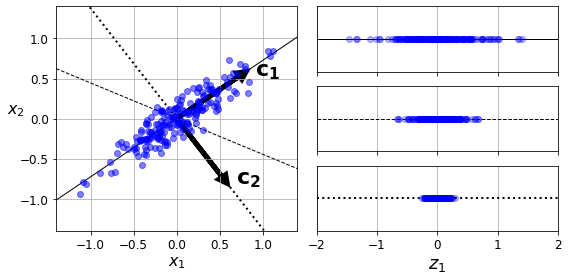

Figure 8-7


In [2]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0], [0, 1]])) #Stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) #Rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X.dot(u1.reshape(-1, 1)) 
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8, 4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=1)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=1)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, head_length=0.1,
          length_includes_head=True, fc="k", ec="k")
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, head_length=0.1,
          length_includes_head=True, fc="k", ec="k")
plt.text(u1[0] + 0.1, u1[1] -0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", rotation=0, fontsize=16)
plt.grid(True)

plt.subplot2grid((3, 2), (0, 1),)
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$z_1$", fontsize=18)
plt.axis([-2, 2, -1, 1])
plt.grid(True)

save_fig("Dimensionality reduction - Selecting the subspace to project on")
plt.show()
print("Figure 8-7")

##### Principal components

**PCA identifies the axis that acconts for the most variance in the training set.** In figure 8-7, its the solid line. **It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance.** If it were a higher-dimensional dataset, PCA would keep on finding other axes that are orthogonol to previous axes - as many as the number of dimensions in the dataset

The $i^{th}$ axis is called the $i^{th}$ _principal component_ (PC) of the data. In figure 8-7, the first PC is the axis in which vector $c_1$ lies, and the second PC is the axis in which vector $c_2$ lies

**So how can you find the principal components of a training set?**

There's a standard matrix factorization technique called ***Singular Value Decomposition*** (SVD) that can decompose the training set matrix $X$ into the matrix multiplication of three matrices $U \sum V^T$, where $V$ contains the unit vectors that define all the principal components that we're looking for (equation 8-1)

- $U$ - An $m \times n$ matrix. The columns are called _left singular vectors_
- $\sum$ - An $n \times n$ diagonal matrix. The elements are only nonzero on the diagonal, and are called _singular values_
- $V^t$ - An $n \times n$ matrix. The rows contain the elements of _right singular vectors_

<img src="images/Dimensionality reduction - PCA, principal component matrix.png">

Let's first build a 3D dataset and then use Numpy's _svd()_ function to obtain all the principal components of the training set, then extracts the two unit vectors that define the first 2 PCs

Build 3D dataset:

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 -0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w1 + noise * np.random.randn(m)

In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [5]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [6]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

> PCA assumes that the dataset is centered around the origin. Scikit Learn's PCA classes takes care of that. If you **implement PCA by yourself, like in the preceding example, or use other libararies, don't forget to center the data**

##### Projecting down to d dimensions

The next step, after identifying all the principal components, is reducing the dimensionality of the dataset down to ***d*** dimensions by porjecting it onto the hyperplane defined by the first _d_ PC (principal component). This hyperplane ensures that the projection will preserve as much variance as possible

To project the training set onto the hyperplane and obtain a reduced dataset $X_d-proj$ of dimensionality ***d***:
- Compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$
    - $W_d$ is defined as the matrix containing the first ***d*** columns of $V$, as shown in equation 8-2

<img src="images/Dimensionality reduction - PCA, projecting the training set down to d dimensions.png">

Let's project the training set onto the plane defined by the first 2 PC's

In [7]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [8]:
X2D_using_svd = X2D

The **process above** shows how to reduce the dimensionality of any dataset down to any number of dimensions, while preserving as much variance as possible

##### Using Scikit Learn

Scikit Learn's PCA class uses SVD decomposition to implement PCA, just as we did earlier. Let's apply PCA to reduce the dimensionality of the dataset down to 2 dimensions (Scikit Learn automatically takes care of centering the data)

In [9]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

After fitting PCA transformer to the dataset, its ***components_*** attribute holds the transpose of $w_d$ (e.g, the unit vector that defines the first principal component is equal to ***pca.components_.T[:, 0]***)

In [10]:
X2D[:5]

array([[ 1.23139275,  0.41881395],
       [-0.0703487 , -0.37067823],
       [ 1.1473837 ,  0.35635335],
       [ 0.90073606, -0.28475069],
       [ 0.74472406, -0.20230269]])

In [11]:
X2D_using_svd[:5]

array([[-1.23139275, -0.41881395],
       [ 0.0703487 ,  0.37067823],
       [-1.1473837 , -0.35635335],
       [-0.90073606,  0.28475069],
       [-0.74472406,  0.20230269]])

**Note**, running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. **In the exmpale above, PCA using Scikit Learn gives the same projections as the one given by the SVD approach, except both axes are flipped**

In [12]:
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace)

In [13]:
X3D_inv = pca.inverse_transform(X2D)

You should take into account that some information loss occured during the projection step (from 3D to 2D subspace), so the recovered 3D points aren't exactly equal to the original 3D point

In [14]:
np.allclose(X3D_inv, X)

False

Let's compute the reconstruction error

In [15]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.01106161829593676

**The inverse transform in the SVD approach looks like this**

In [16]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstruction from both methods aren't identical because Scikit Learn's PCA class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction

In [17]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

As stated above, after PCA's fit_transform the dataset, PCA object gives access to the PC's (principal component) that it computed

In [18]:
pca.components_

array([[-0.94762989, -0.29402842, -0.12467913],
       [ 0.30510395, -0.94884017, -0.08132593]])

Compare to the first two PC's (principal component) computed using SVD method

In [19]:
Vt[:2]

array([[ 0.94762989,  0.29402842,  0.12467913],
       [-0.30510395,  0.94884017,  0.08132593]])

**Notice that the axes are flipped**

##### Explained variance ration

PCA class also offers the ***explained_variance_ratio_*** variable. The ration indicates the proportion of the dataset's variance that lies along each PC (prinicipal component). 

Let's look at the explained variance rations of the first 2 components of the 3D dataset represented in figure 8-2

In [20]:
pca.explained_variance_ratio_

array([0.84720206, 0.14032689])

The first dimension explains 91.69% of the variance, while the second explains 8.29%

By projecting down to 2D, we lost about 0.02% (1 - (91.69 + 8.29)) variance

In [21]:
#1 -pca.explained_variance_ratio_.sum().

Let's compute the explained variance ratio using the SVD approach (recall that s is the diagonal of the matrix S)

In [22]:
np.square(s) / np.square(s).sum()

array([0.84720206, 0.14032689, 0.01247105])

Now, we'll plot figures for the **projection sections**

Utility class to draw 3D arrows (copied from http://stackoverflow.com/questions/11140163)

In [23]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d =  xs, ys, zs
    
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y

In [24]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Plot the 3D dataset, the plane and the projections on the plane

Saving figure Dimensionality reduction - Projection, 3D dataset lying close to a 2D subspace


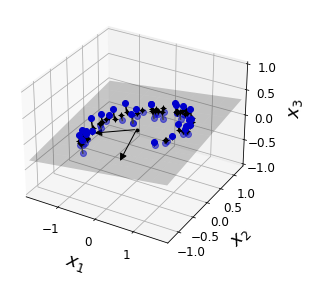

Figure 8-2


In [25]:
fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection="3d")

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("Dimensionality reduction - Projection, 3D dataset lying close to a 2D subspace")
plt.show()
print("Figure 8-2")

Saving figure Dimensionality reduction - Projection, new 2D dataset after projection
Figure 8-3


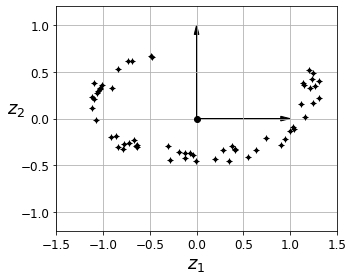

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

plt.plot(X2D[:, 0], X2D[:, 1], "k+")
plt.plot(X2D[:, 0], X2D[:, 1], "k.")
plt.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, head_length=0.1, length_includes_head=True,
        fc="k", ec="k")
ax.arrow(0, 0, 1, 0, head_width=0.05, head_length=0.1, length_includes_head=True,
        fc="k", ec="k")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", rotation=0, fontsize=18)
plt.axis([-1.5, 1.5, -1.2, 1.2])
plt.grid(True)
save_fig("Dimensionality reduction - Projection, new 2D dataset after projection")
print("Figure 8-3")

Now, we'll plot figures for the **manifold learning sections**

In [27]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Saving figure Dimensionality reduction - Manifold learning, Swiss roll dataset


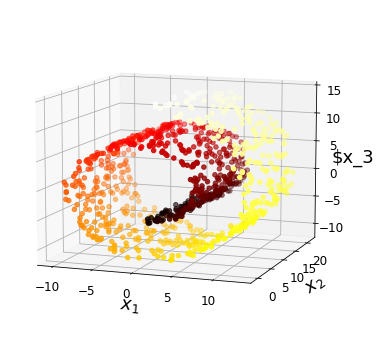

Figure 8-4


In [28]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("Dimensionality reduction - Manifold learning, Swiss roll dataset")
plt.show()
print("Figure 8-4")

Saving figure Dimensionality reduction - Manifold learning, squashing by projection vs unrolling


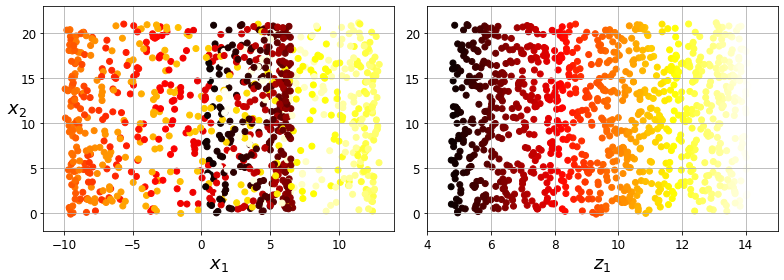

Figure 8-5


In [29]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", rotation=0, fontsize=18)
plt.axis(axes[:4])
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.axis([4, 15, axes[2], axes[3]])
plt.grid(True)

save_fig("Dimensionality reduction - Manifold learning, squashing by projection vs unrolling")
plt.show()
print("Figure 8-5")

Saving figure Dimensionality reduction - Manifold learning, manifold 3D decision boundary plot1R


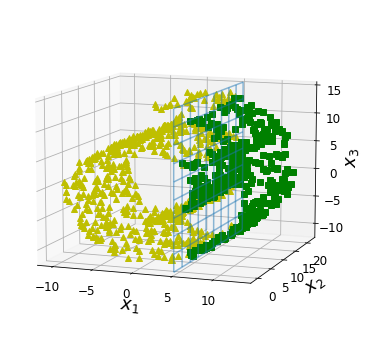

Figure 8-6 3D top
Saving figure Dimensionality reduction - Manifold learning, manifold 2D decision boundary plot1L


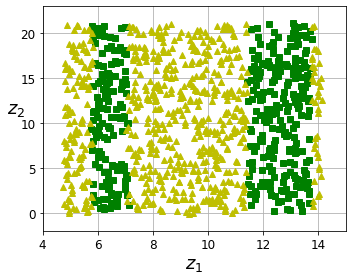

Figure 8-6 2D top
Saving figure Dimensionality reduction - Manifold learning, manifold 3D decision boundary plot2R


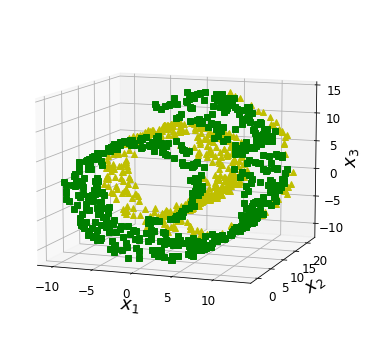

Figure 8-6 3D bottom
Saving figure Dimensionality reduction - Manifold learning, manifold 2D decision boundary plot2L


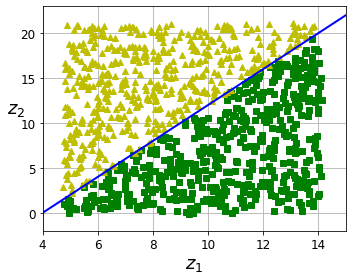

Figure 8-6 2D bottom


In [30]:
axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection="3d")

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("Dimensionality reduction - Manifold learning, manifold 3D decision boundary plot1R")
plt.show()
print("Figure 8-6 3D top")

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", rotation=0, fontsize=18)
plt.axis([4, 15, axes[2], axes[3]])
plt.grid(True)

save_fig("Dimensionality reduction - Manifold learning, manifold 2D decision boundary plot1L")
plt.show()
print("Figure 8-6 2D top")

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection="3d")

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("Dimensionality reduction - Manifold learning, manifold 3D decision boundary plot2R")
plt.show()
print("Figure 8-6 3D bottom")

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", rotation=0, fontsize=18)
plt.grid(True)

save_fig("Dimensionality reduction - Manifold learning, manifold 2D decision boundary plot2L")
plt.show()
print("Figure 8-6 2D bottom")

##### Choosing the right number of dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it's simpler to **choose the number of dimensions that add up to a sufficiently large proportion of variance (e.g, 95%).** Unless you're reducing dimensionality for visualization - in that case you'll want to reduce the dimensionality down to 2 or 3

Let's use the MNIST dataset to perform PCA without reducing dimensionality, and compute the number of dimensions required to preserve 95% of the the training set's variance

In [2]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [35]:
d

154

So we need a minimum of 154 dimensions in order to preserve 95% of the training set's variance

It's possible to set ***n_components=d*** and run PCA again. **But there's a better option:** instead of specifying the number of principal components you want to preserve, you can set ***n_components*** to be a float between 0.0 - 1.0, indicating the ration of variance you wish to preserve:

In [36]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [37]:
pca.n_components_

154

In [38]:
np.sum(pca.explained_variance_ratio_)

0.9504326468621525

**Another option** is to plot the explained variance as a function of the number of dimensions (plot ***cumsum***, figure 8-8). There will usually be an elbow in the curve, where the explained variance stops growing fast. In this case, you can see that reducing dimensionality down to around 100 wouldn't lose too much variance

Saving figure Dimensionality reduction - PCA, choosing the right number of dimensions


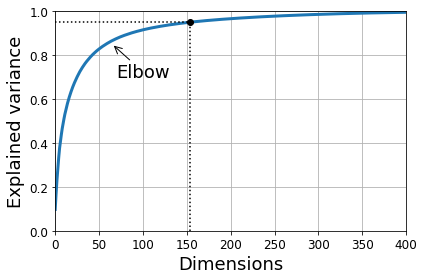

Figure 8-8


In [42]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7), 
             arrowprops=dict(arrowstyle="->"), fontsize=18)
plt.xlabel("Dimensions", fontsize=18)
plt.ylabel("Explained variance", fontsize=18)
plt.axis([0, 400, 0, 1])
plt.grid(True)

save_fig("Dimensionality reduction - PCA, choosing the right number of dimensions")
plt.show()
print("Figure 8-8")

##### PCA for compression

After the dimensionality reduction, the training set takes up much less space. There's 154 features instead of the original 784 features. So, while most of the variance is preserved, 95% of it, the dataset is now less than 20% of it's original size. 

This is a reasonable compression ratio, and decreasing the size will help speed up a classification algorithm tremendously (e.g, SVM)

**It's possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection.** This won't give back the original data, since the projection to a lower dimension lost a bit of information (within the 5% variance that was dropped), nonetheless it will be very close to the original data. 

**The mean squared distance between the original data and the reconstructed data (compressed and the decompressed) is called _reconstruction error_.**

Let's illustrate this assumption

In [54]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [65]:
def plot_digits(instances, images_per_row=5, **options):
    size=28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

Saving figure Dimensionality reduction - PCA, MNIST compression with preserved variance of 95%
Figure 8-9


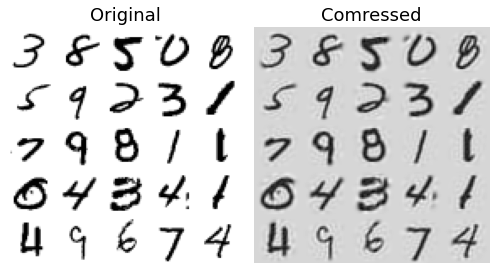

In [66]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=18)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Comressed", fontsize=18)

save_fig("Dimensionality reduction - PCA, MNIST compression with preserved variance of 95%")
print("Figure 8-9")

As you can see, there's a slight quality loss after the transformation back to the original number of features, but the digits are still mostly intact.

The equation of the inverse transformation is shown below

<img src="images/Dimensionality reduction - PCA, inverse transformation back to the original.png">

##### Randomized PCA

If you set the ***svd_solver="randomized"***, Scikit Learn uses a stochastic algorithm called ***Randomized PCA*** that quickly finds an approximation of the first ***d*** principal components. Its computational complexity is $O(m \times d^2) + O(d^3)$, instead of $O(m \times n^2) + O(n^3)$ for the full SVD approach, so it's dramatically faster than full SVD when ***d*** is much smaller than ***n***

By default, ***svd_solver="auto***: Scikit Learn automatically uses the randomized PCA algorithm if ***m*** or ***n*** is greater than 500 and ***d*** is less than 80% of ***m*** or ***n***, or else it uses the full SVD approach. Setting ***svd_solver="full"*** will force Scikit Learn to use full SVD

##### Incremetal PCA

**One problem with the preceding implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run.** 

***Incremental PCA*** (IPCA) tries to address this issue. They allow you to split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time.

This approach is very useful for large training sets and for applying PCA online when new instances arrive.

Let's revisit the MNIST dataset and split it to 100 mini-batches (with ***array_split()***), feed it to ***IncrementalPCA*** and reduce the dimensionality to 154. **Note**, ***partial_fit()*** must be called when using mini-bathces, rather then ***fit()*** for the whole dataset

In [67]:
X_reduced_pca = X_reduced

In [69]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [70]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

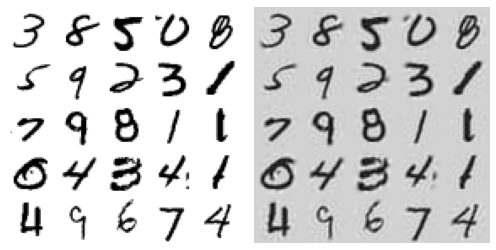

In [73]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [74]:
X_reduced_inc_pca = X_reduced

Let's compare the results of transforming MNIST using regular PCA and Incremental PCA. First, the means are equal:

In [76]:
np.allclose(pca.mean_, inc_pca.mean_)

True

But the results aren't exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [77]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

**Alternatively**, you can use Numpy's ***memmap*** class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory - the class loads only the data it needs in memory, when it needs it. 

Since the ***IncrementalPCA*** uses only a small part of the array at any given time, the memory usage remains under control. This makes it possible to use ***fit()***

Let's create the memmap() structure and copy the MNIST data into it. This would typically done by a first program

In [83]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype="float32", mode="write", shape=(m, n))
X_mm[:] = X_train

Deleting the ***memmap()*** object will trigger its Python finalizer, which ensures that the data is saved to disk

In [84]:
del X_mm

Next, another program will load the data and use it for training

In [86]:
X_mm = np.memmap(filename, dtype="float32", mode="write", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

C:\Users\Jason\anaconda3\lib\site-packages\sklearn\decomposition\_incremental_pca.py:304: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)


IncrementalPCA(batch_size=525, n_components=154)

##### Time complexity 

Let's time regular ***PCA*** against ***Incremental PCA** and ***Randomized PCA***, for various number of principal components

In [87]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [91]:
for n_components in (2, 10, 154):
    print("n_components: ", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, svd_solver="randomized",
                  random_state=42)
    for name, pca in (("PCA", regular_pca), ("Incremental PCA", inc_pca),
                      ("Randomized PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components:  2
    PCA: 3.9 seconds
    Incremental PCA: 6.4 seconds
    Randomized PCA: 0.8 seconds
n_components:  10
    PCA: 3.3 seconds
    Incremental PCA: 6.1 seconds
    Randomized PCA: 0.9 seconds
n_components:  154
    PCA: 3.4 seconds
    Incremental PCA: 7.9 seconds
    Randomized PCA: 2.4 seconds


Now, let's compare ***PCA*** and ***Randomized PCA*** for datasets of different sizes (number of instances):

Saving figure Dimensionality reduction - PCA, PCA and Randomized PCA time complexity - Various datasets


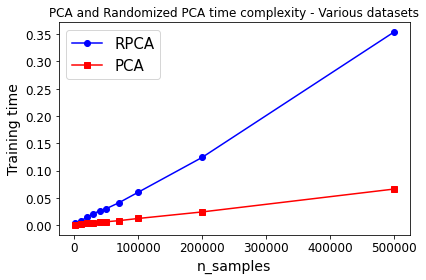

In [102]:
time_rpca = []
time_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    time_rpca.append(t2-t1)
    
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    time_pca.append(t2-t1)

plt.plot(sizes, time_rpca, "b-o", label="RPCA")
plt.plot(sizes, time_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left", fontsize=15)
plt.title("PCA and Randomized PCA time complexity - Various datasets")

save_fig("Dimensionality reduction - PCA, PCA and Randomized PCA time complexity - Various datasets")

And now let's compare their performance on datasets of 2000 instances with various number of features:

Saving figure Dimensionality reduction - PCA, PCA and Randomized PCA time complexity - Various features


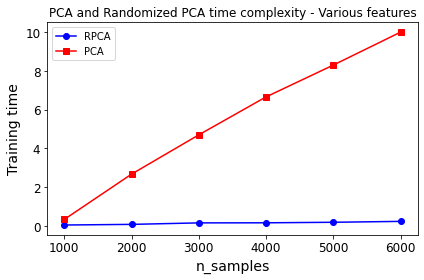

In [103]:
time_rpca = []
time_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    time_rpca.append(t2-t1)
    
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    time_pca.append(t2-t1)

plt.plot(sizes, time_rpca, "b-o", label="RPCA")
plt.plot(sizes, time_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity - Various features")

save_fig("Dimensionality reduction - PCA, PCA and Randomized PCA time complexity - Various features")

We saw that when it comes to the **size of datasets, _Randomized PCA_ takes longer to train as the dataset increases, while _PCA_ is faster**. However, **when more features are introduced, _Randomized PCA_ is extremely fast, while _PCA_ takes longer**  

# End Of Section: Technique #1 PCA

# Section: Technique #2 Kernell PCA (Projection approach)

The kernel trick is a mathematical technique that implicitly maps instances into a very high-dimensional space (called the feature space), enabling nonlinear classification and regression with Support Vector Machines. **Recall** that a linear decision boundary in the high-dimensional feature space **corresponds** to a complex nonlinear decision boundary in the _original space_

***Kernel PCA (kPCA)*** uses the same mathematical trick, making it possible to perform complex nonlinear projections for dimensionality reduction. It's good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold

Let's see how we can do it with Scikit Learns KernelPCA

In [9]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [10]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Figure 8-10 shows the Swiss Roll dataset, reduced to 2 dimensions using linear kernel (equivalent to simply using the PCA class), an RBF kernel and a sigmoid kernel

Saving figure Dimensionality reduction - KernelPCA, Swiss roll reduced to 2D using kPCA with different kernels


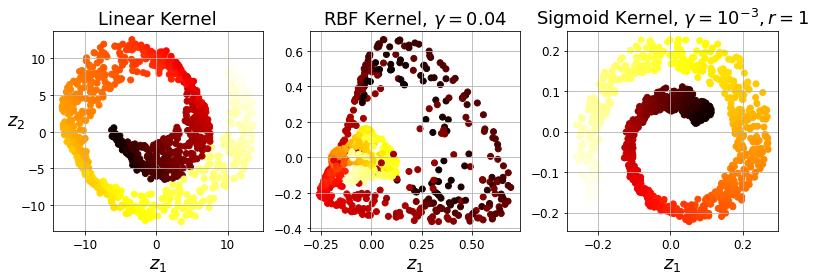

Figure 8-10


In [14]:
lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1,
                    fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear Kernel"),
                            (132, rbf_pca, "RBF Kernel, $\gamma=0.04$"),
                            (133, sig_pca, "Sigmoid Kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0, fontsize=18)
    plt.title(title, fontsize=18)
    plt.grid(True)

save_fig("Dimensionality reduction - KernelPCA, Swiss roll reduced to 2D using kPCA with different kernels")
plt.show()
print("Figure 8-10")

Saving figure Dimensionality reduction - KernelPCA, preimage plot


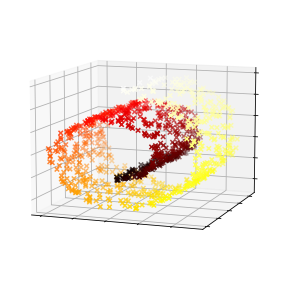

In [21]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection="3d")
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot,
          marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("Dimensionality reduction - KernelPCA, preimage plot", tight_layout=False)
plt.show()

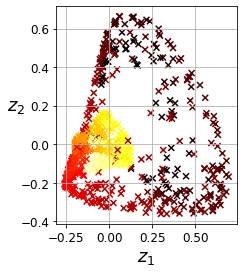

In [23]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", rotation=0, fontsize=18)
plt.grid(True)

##### Selecting a Kernel and tuning hyperparameters

**kPCA is an _unsupervised learning algorithm_, thus there aren't any performance measures that can help select the best kernel and hyperparameters.** 

That said, **dimensionality reduction is often a preparation step for a supervised learning task (e.g, classification), thus you can use grid search to select the kernel and hyperparameters that lead to the best performance** on that task. 

Let's create a **two-step pipeline**, first reducing the dimensionality to 2D with kPCA, then applying Logistic Regression for classification. Lastly, it will use ***GridSearchCV*** to find the best kernel and ***gamma*** value for kPCA in order to get the best classification accuracy at the end of the pipeline

In [30]:
clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression(solver="lbfgs"))
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10) ,
    "kpca__kernel": ["rbf", "sigmoid"]
}]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

Let's check the best kernel and gamma

In [31]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


**Another approach is that of an unsupervised**, you select the kernel and hyperparameter that yield the lowest reconstruction error. **Note that reconstruction isn't as easy with linear PCA**. 

Let's explain, figure 8-11 show the original Swiss roll on 3D (top left) and the resulting 2D after kPCA has been applied to it with a RBF kernel (top right). 

Thanks to the kernel trick, this step is equivalent to using the  ***feature map*** $\varphi$ to map the training set to an infinite dimensional feature space (bottom right), then projecting that transformed training set down to 2D using a linear PCA (regular PCA).

If we could invert the linear PCA step for a given instance in the reduced space, the reconstructed point would lie in feature space, **not in the original space*** (e.g, like the one represented by an X in the diagram). 

Since the feature space is infinite dimensional, we can't compute the reconstruction point, therefore we can't compute the true reconstruction error.

Fortunately, it's possible to find a point in the original space that would map close to the reconstructed point. This is called the reconstruction ***pre-image***. 

Once you have this ***pre-image***, you can measure it's squared distance to the original instance. Then, it's possible to select the kernel and hyperparameter that minimizes this reconstruction ***pre-image*** error.

<img src="images/Dimensionality reduction - KernelPCA, reconstruction and preimage error.png" style="max-width:500px;">

In order to perform this reconstruction, we cabn train a supervised regression model, with the projected instances as the training set and the original instances as the targets. Scikit Learn does this automatically if you set ***fit_inverse_transform=True***: (we'll use the best kernel and gamma from grid_search)

> By default, ***fit_inverse_transform=False*** and KernelPCA has no ***inverse_transform*** method. This method gets created only after setting ***fit_inverse_transform=True***

In [32]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

And now we can compute the reconstruction **pre-image** error

In [36]:
mean_squared_error(X, X_preimage)

1.0563391142626335e-26

# End OfSection: Technique #2 Kernell PCA

# Section: Technique #3 LLE (Manifold Learning approach)

***Locally Linear Embedding*** (LLE) is a powerful ***nonlinear dimensionality reduction*** (NLDR) technique that uses the **Manifold Learning** approach and doesn't rely on projections.

In a nutshell, this is how LLE works:
- Measures how each training instance linearly relates to its closest neighbors (c.n)
- Look for a low-dimensional representation of the training set where these **local relationships are best preserved**

These steps make this approach particularly good at unroliing twisted manifolds, especially when there is not too much noise

Let's unroll the Swiss roll dataset using Scikit Learn and make a plot

In [18]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)


lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Saving figure LLE - Unrolling Swiss roll


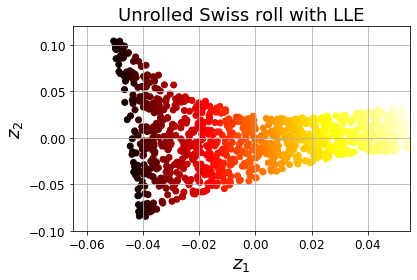

Figure 8-12


In [19]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.title("Unrolled Swiss roll with LLE", fontsize=18)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("LLE - Unrolling Swiss roll")
plt.show()
print("Figure 8-12")

The Swiss roll is completely unrolled, and the distances are locally well preserved. **However**, distances aren't preserved on larger scale: **the left part is stretched**, while **the right part is squeezed.** Nevertheless, LLE did a pretty good job at modeling the manifold

**Expnading on how LLE works:**
- **The first step** - For each training instance $x^{(i)}$, the algorithm identifies its $k$ closest neighbor (we used $k = 10$ to unroll the Swiss roll)
    - Then tries to reconstruct $x^{(1)} as a linear function of these neighbors$
        - More specifically, it finds the weights $w_{i,j}$ such that the squared distance between $x^{(i)}$ and $\sum^{m}_{j = 1} w_{i,j} x^{(j)}$ is as small as possibvle, assuming $w_{i,j} = 0$ if $x^{(j)}$ is'nt one of the $k$ closest  neighbors of $x^{(i)}$
        
Thus, the first step of LLE is the constrained optimization problem described in equation 8-4, where $W$ is the weight matrix containing all the weigth $w_{i,j}$. The second constraint simply normalizes the weights for each training instances $x^{(i)}$

<img src="images/LLE - Step one, linearly modeling local relationships.png">

After this step, the weight matrix $\widehat W$ (containing the weights $\widehat w_{i,j}$) encondes the local linear relationships between the training instances.

- **The second step** - Map the training instances into a $d$-dimensional space (where $d<n$) while preserving these local relationships as much as possible.
    - If $z^{(i)}$ is the image of $x^{(i)}$ in this $d$-dimensional space, then we want the squared distance between $z^{(i)}$ and $\sum ^m_{j=1} \widehat w_{i,j} z^{(j)}$ to be as small as possible.

This idea leads to the unconstrained optimization problem described in equation 8-5. It resembles the firs step, but instead of keeping the instances fixed and finding the optimal weights, we're doing the reverse: keeping the weights fixed and finding the optimal position of the instances' images in the low-dimensional space. ($Z$ is the matrix containing all $z^{(i)}$)

<img src="images/LLE - Step two, reduing dimensionality while preserving relationships.png">

**Computational complexity of LLE using Scikit Learn**:
- Finding the nearest $k$ - $O(m log(m)n log(k)$
- Optimizing the weights - $O(mnk^3)$
- Constructing the low-dimensional representations - $O(dm^2)$

Unfortunately, the $m^2$ in the last term makes this algorithm scale poorly to very large datasets

# Section: Technique #3 LLE 

# Section: Other Dimensionality Reduction Techniques

Here are some other popular dimensionality reduction techniques implemented with Scikit Learn:

- _Random Projections_
    - Projects the data to a lower-dimensional space using a random linear projection. This sounds counterintuitive, but it's very likely to preserve distances well. The quality of the dimensionality reduction depends on the number of instances and the target dimensionality, but not on the initial dimensionality. 
    
- _Multidimensional Scaling (MDS)_
    - Reduces dimensionality while trying to preserve the distances between the instances.
    
- _Isomap_
    - Creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the _geodesic distances_ (= the shortest path between two nodes) between the instances. 
    
- t-Distributed Stochastic Neighbor Embedding (t-SNE)
    - Reduces dimensionality while trying to keep similar instances close and dissimalr instances apart. It's mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g, to visualize the MNIST images in 2D)
    
- Linear Discriminant Analysis (LDA)
    - Is a classification algorithm, but during training it learns the most descriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit of this approach is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as an SVM classifier

Let's use some of the aforementioned techniques to reduce the Swiss roll

In [23]:
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

Saving figure LLE - Other dimensionality reduction techniques of unrolling the Swiss roll


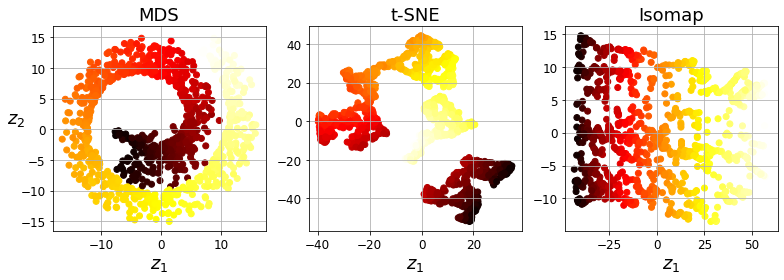

Figure 8-12


In [27]:
titles = ["MDS", "t-SNE", "Isomap"]

plt.figure(figsize=(11, 4))
for subplot, title, X_reduced in zip ((131, 132, 133), titles,
                                      (X_reduced_mds, X_reduced_tsne,
                                       X_reduced_isomap)):
    plt.subplot(subplot)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.title(title, fontsize=18)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0, fontsize=18)
    plt.grid(True)

save_fig("LLE - Other dimensionality reduction techniques of unrolling the Swiss roll")
plt.show()
print("Figure 8-12")

# End OF Section: Other Dimensionality Reduction Techniques

# Section: Exercise solutions

##### See appendix A for solutions: Questions 1-8

### 9

Load the MNIST dataset (introduced in Chapter 3) and split it into a training set
and a test set (take the first 60,000 instances for training, and the remaining
10,000 for testing). Train a Random Forest classifier on the dataset and time how
long it takes, then evaluate the resulting model on the test set. Next, use PCA to
reduce the dataset’s dimensionality, with an explained variance ratio of 95%.
Train a new Random Forest classifier on the reduced dataset and see how long it
takes. Was training much faster? Next, evaluate the classifier on the test set. How
does it compare to the previous classifier?

Let's solve the questions:

- Load the MNIST dataset (introduced in Chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing)

In [4]:
X_train = mnist["data"][:60000]
y_train = mnist["target"][:60000]

X_test = mnist["data"][60000:]
y_test = mnist["target"][60000:]

-  Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.

In [15]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [16]:
print("Training took: {:.2f}s".format(t1-t0))

Training took: 41.23s


In [17]:
y_pred = rnd_clf.predict(X_test)
accuracy_score = accuracy_score(y_test, y_pred)

print("The evaluation of Random Forest on the test had a - {:.4f} accuracy score".format(accuracy_score))

The evaluation of Random Forest on the test had a - 0.9705 accuracy score


-  Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%

In [11]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

- Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? 

In [12]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t01 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t11 = time.time()

In [13]:
print("Training took: {:.2f}s".format(t11-t01))

Training took: 91.79s


> The training more than twice slower than before. Dimensionality reduction doesn't always lead to faster training time: it depends on the dataset, the model and the algorithm. Trying a softmax classifier instead of a random forest classifier, will yeild a faster training when using PCA.

- Next, evaluate the classifier on the test set. How does it compare to the previous classifier?

In [14]:
X_test_reduced = pca.transform(X_test)
y_pred2 = rnd_clf2.predict(X_test_reduced)
accuracy_score2 = accuracy_score(y_test, y_pred2)

print("The evaluation of Random Forest 2 on the test set had a - {:.4f} accuracy score".format(accuracy_score2))

The evaluation of Random Forest 2 on the test set had a - 0.9481 accuracy score


> It's common for performance to drop slightly when reducing dimensionality, becuase we do lose some useful signal in the process. However, the performance drop in this case is rather severe. So PCA didn't help: it slowed down training and reduced performance

- Let's check if softmax regression can help:

In [6]:
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs",
                             random_state=42)
t02 = time.time()
log_clf.fit(X_train, y_train)
t12 = time.time()

C:\Users\Jason\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
print("Training took: {:.2f}".format(t12-t02))

Training took: 8.59


In [18]:
y_pred3 = log_clf.predict(X_test)
accuracy_score3 = accuracy_score(y_test, y_pred3)

print("The evaluation of Softmax Regression on the test set had a - {:.4f} accuracy score".format(accuracy_score3))

TypeError: 'numpy.float64' object is not callable

> A very slight drop in performance, which might be a reasonable price for a 2X speedup, depending on the application

### 10

Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the
result using Matplotlib. You can use a scatterplot using 10 different colors to represent
each image’s target class. Alternatively, you can replace each dot in the
scatterplot with the corresponding instance’s class (a digit from 0 to 9), or even
plot scaled-down versions of the digit images themselves (if you plot all digits,
the visualization will be too cluttered, so you should either draw a random sample
or plot an instance only if no other instance has already been plotted at a
close distance). You should get a nice visualization with well-separated clusters of
digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or
MDS and compare the resulting visualizations.

Let's solve the questions:

- Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image’s target class

    - Dimensionality reduction on the 60K images takes a very long time, so let's only do this on a random subset of 10K images:

In [3]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist["data"][idx]
y = mnist["target"][idx]

In [4]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne2 = tsne.fit_transform(X)

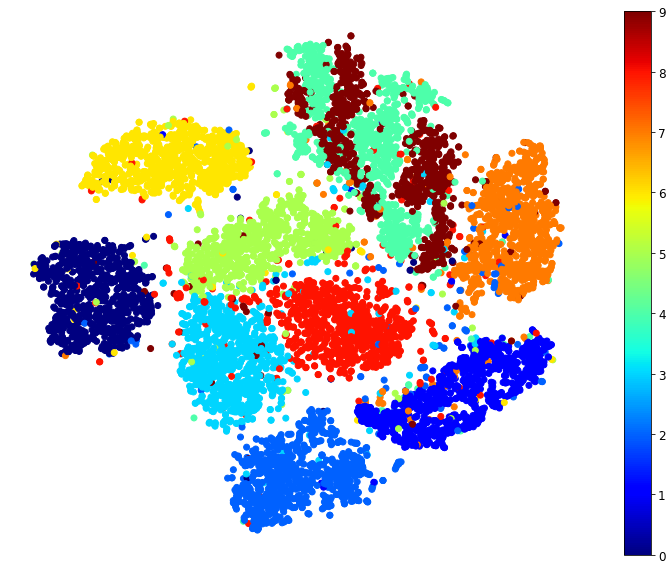

In [5]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced_tsne2[:, 0], X_reduced_tsne2[:, 1], c=y, cmap="jet")
plt.axis("off")
plt.colorbar()
plt.show()

> This plot tells us which numbers are easily distinguishable from the others (e.g, 0s, 6s and most 8s are rather well separated clusters), and also tells use which are often hard to distinguish (e.g, 4s, 9s, 5,s etc)

    - Let's focus on digits 2, 3 and 5 which seem to overlap a lot:

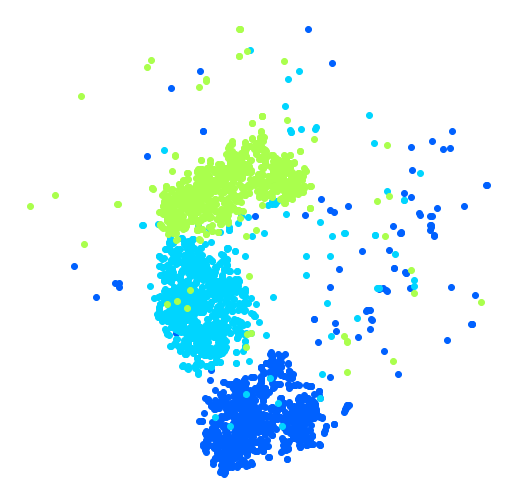

In [14]:
plt.figure(figsize=(9, 9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced_tsne2[y==digit, 0], X_reduced_tsne2[y==digit, 1],
                c=[cmap(digit/9)])
plt.axis("off")
plt.show()

    - Let's see if we can produce a nicer image by running t-SNE on these 3 digits:

In [7]:
idx = (y==2) | (y==3) | (y==5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_reduced_tsne_Subset = tsne_subset.fit_transform(X_subset)

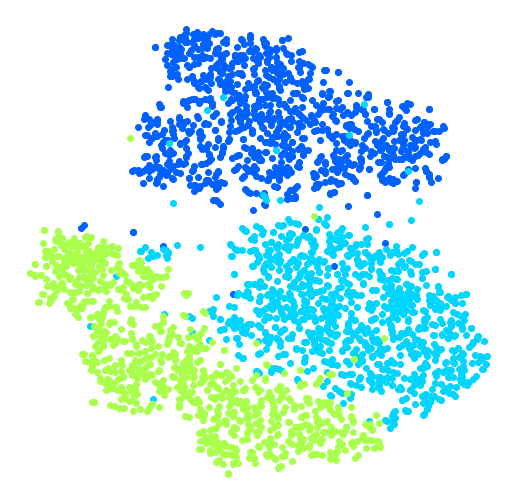

In [8]:
plt.figure(figsize=(9, 9))
for digit in (2, 3, 5):
    plt.scatter(X_reduced_tsne_Subset[y_subset==digit, 0],
                X_reduced_tsne_Subset[y_subset==digit, 1], 
                c=[cmap(digit/9)])
plt.axis("off")
plt.show()

> The cluster has less overlap, yet some 3s (light blue) are still scattered. Moreover, there are two distinct clusters of 2s (blue) and 5s (light green). Let's let visualize a few digits from each cluster, to understand why this is the case

- Alternatively, you can replace each dot in the scatterplot with the corresponding instance’s class (a digit from 0 to 9), or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits

    - We'll create a function - plot_digits(), that will draw a scatterplot plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead

In [40]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    #Scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    #Create the list of coordinates for the digits plotted so far.
    #We pretend that one is already plotted far away at the start, to
    #avoid "if" statements in the loop below
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y==digit, 0], X_normalized[y==digit, 1],
                    c=[cmap(digit/9)])
    plt.axis("off")
    ax = plt.gcf().gca() #Get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_neighbor = np.linalg.norm(neighbors-image_coord, axis=1).min()
        if closest_neighbor > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index]/9), 
                         fontdict={"weight":"bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

    - First, let's write colored digits

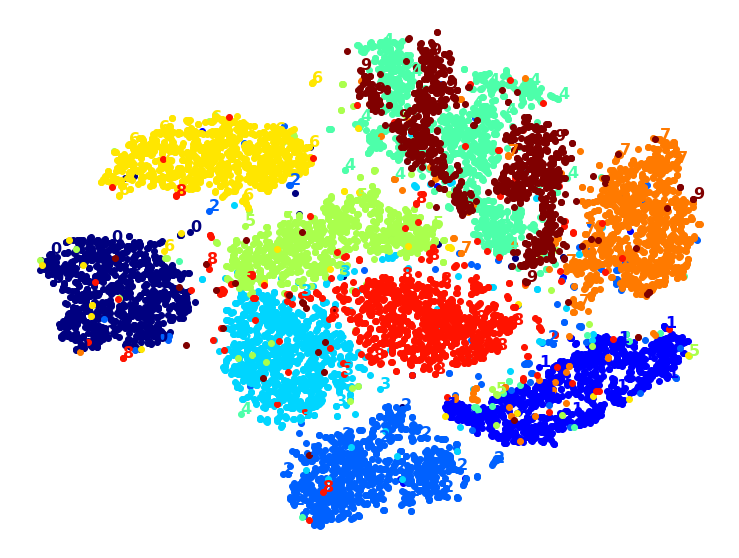

In [41]:
plot_digits(X_reduced_tsne2, y)

    - Let's try with the digit images

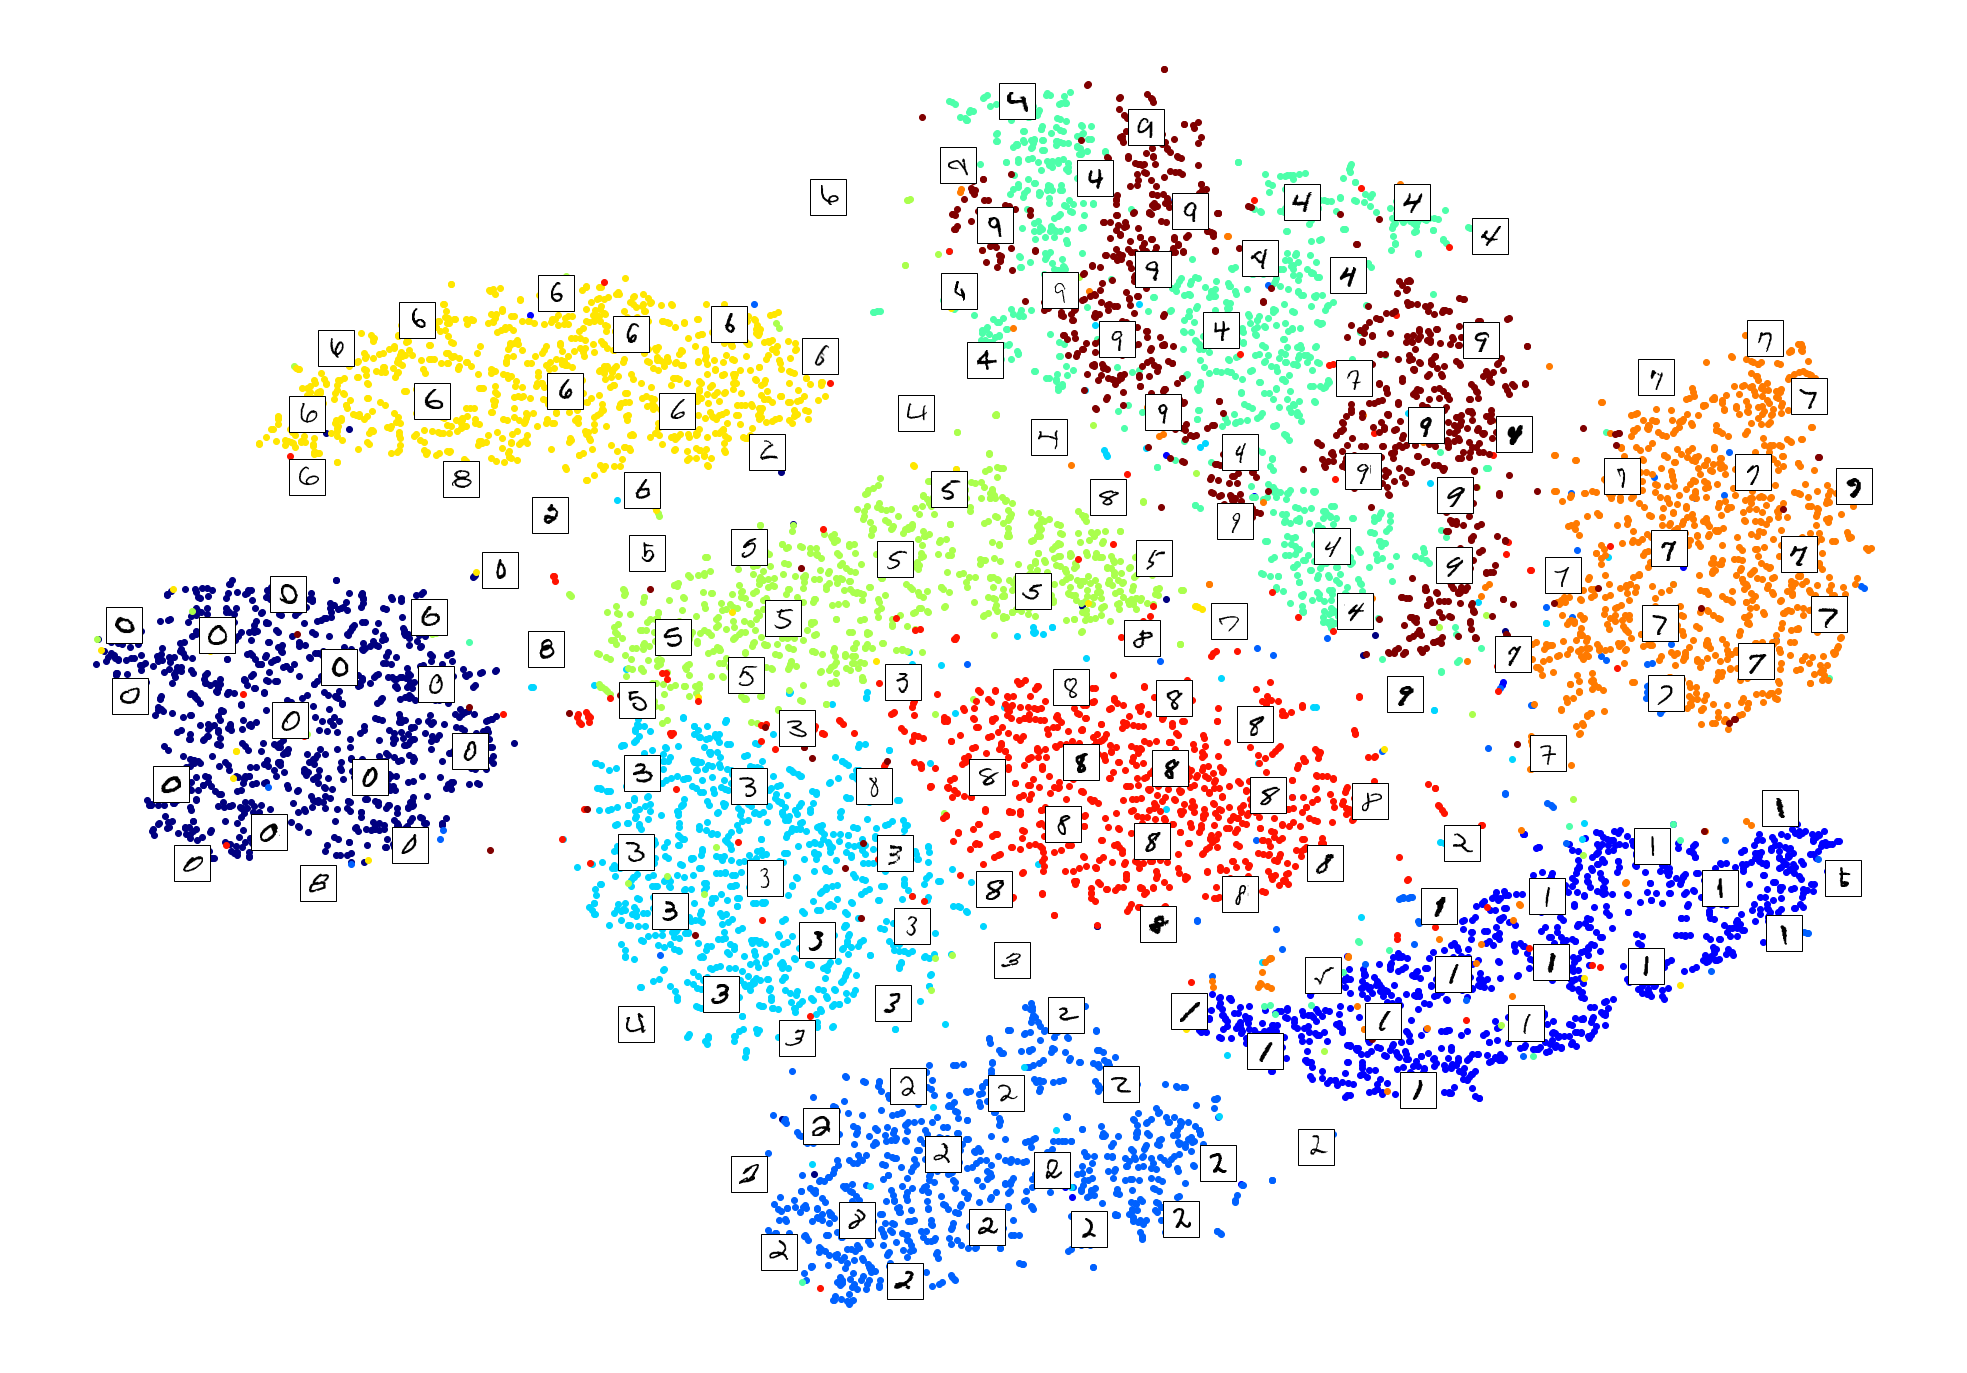

In [42]:
plot_digits(X_reduced_tsne2, y, images=X, figsize=(35,25))

    - Lastly, try it only on the 2s, 3s and 5s

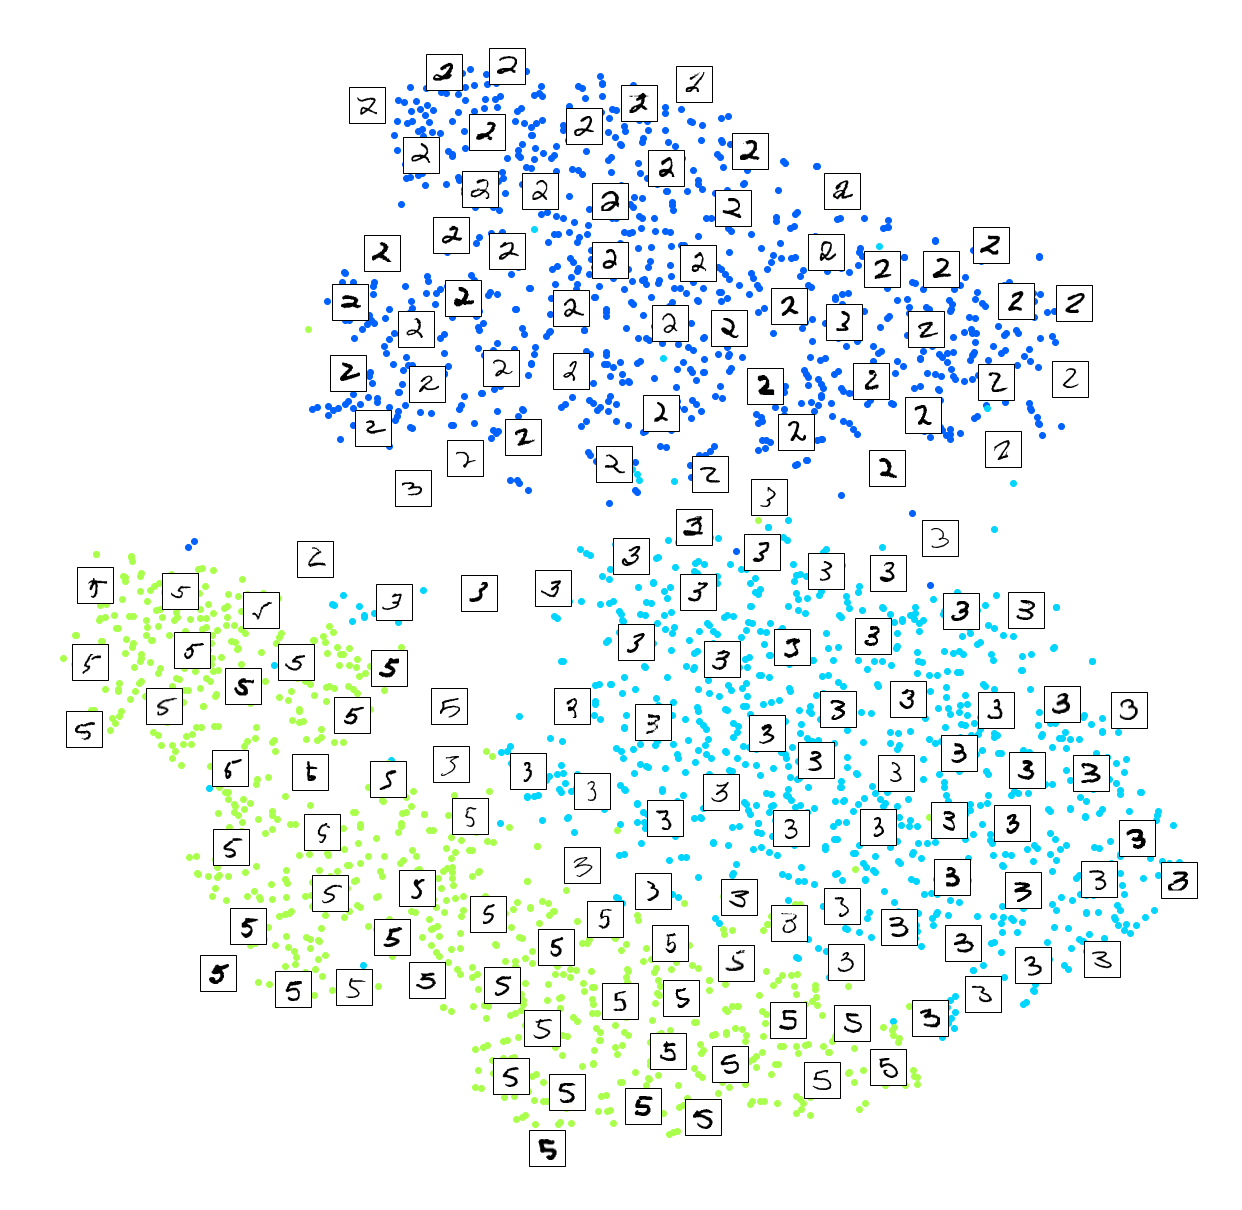

In [43]:
plot_digits(X_reduced_tsne_Subset, y_subset, images=X_subset, figsize=(22, 22))

- Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

PCA took: 0.2s


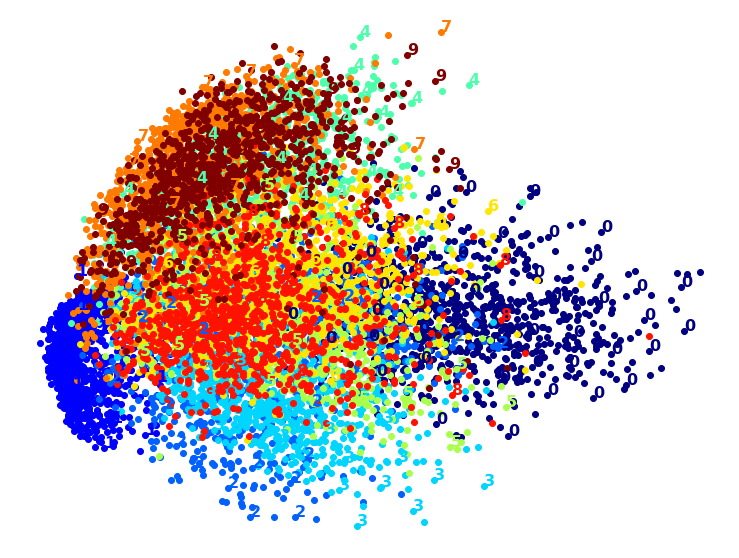

In [45]:
#PCA
t03 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t13 = time.time()
print("PCA took: {:.1f}s".format(t13-t03))
plot_digits(X_pca_reduced, y)

    - PCA was very fast (0.2s). But there's too much overlap between the clusters. Let's try LLE

LLE took: 10.0s


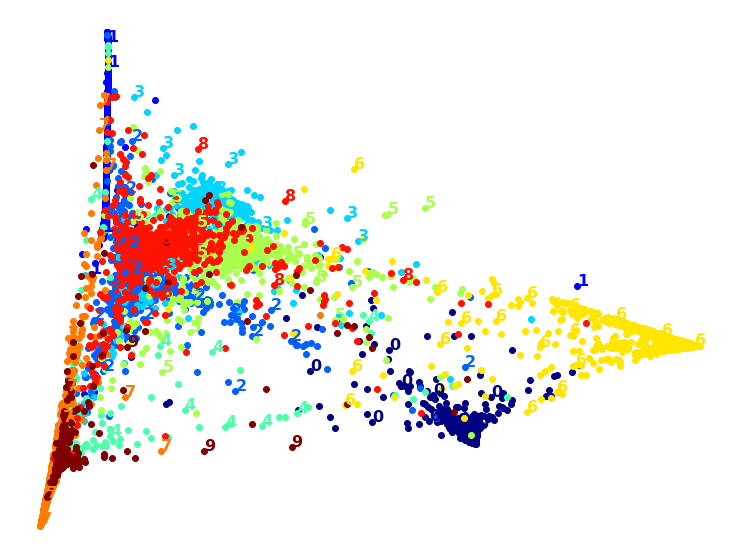

In [47]:
#LLE
t04 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t14 = time.time()
print("LLE took: {:.1f}s".format(t14-t04))
plot_digits(X_lle_reduced, y)
plt.show()

    - LLE took longer than PCA and the results aren't promising. Let's see what happens when we apply PCA first, preserving 95% of the variance 

PCA and LLE took: 11.5s


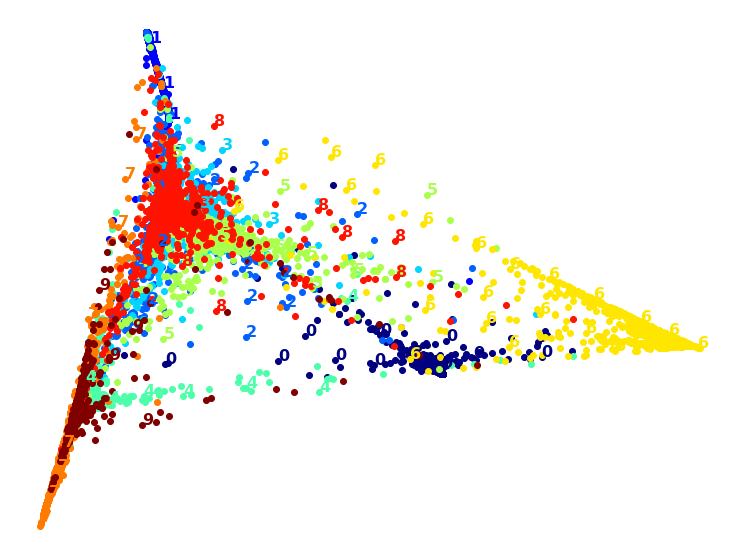

In [49]:
pca_lle_pipeline = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42))
])
t05 = time.time()
X_pcalle_reduced = pca_lle_pipeline.fit_transform(X)
t15 = time.time()
print("PCA and LLE took: {:.1f}s".format(t15-t05))
plot_digits(X_pcalle_reduced, y)
plt.show()

     - The results are similar. Let's try MDS. It will take too long to run it on 10K instances, so we'll just do 2K 

MDS took: 129.0s (for 2000/10000 instances)


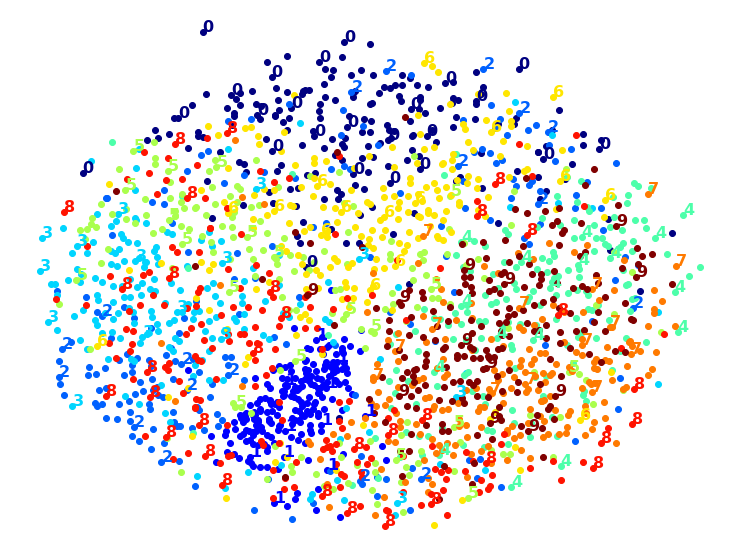

In [53]:
m = 2000
t06 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t16 = time.time()
print("MDS took: {:.1f}s (for 2000/10000 instances)".format(t16-t06))
plot_digits(X_mds_reduced, y[:m])
plt.show()

    - Once again the clusters have too much overlap. Let's try PCA first, perhaps it will be faster

PCA and MDS took: 126.6s


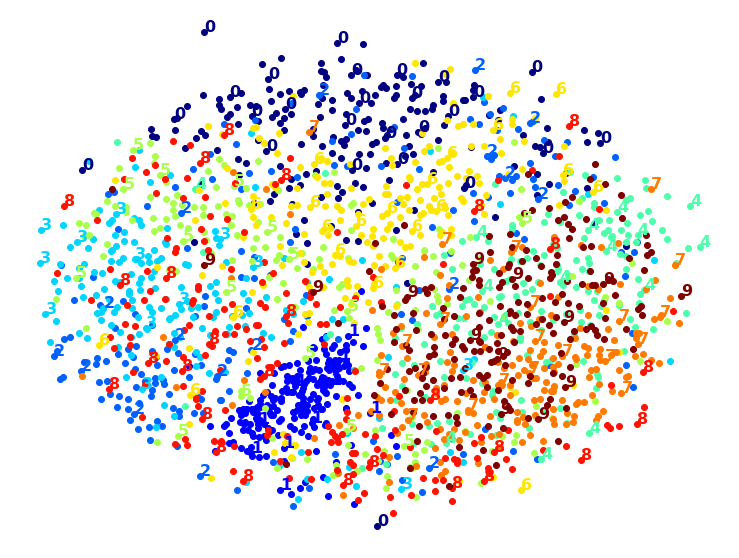

In [54]:
pca_mds_pipeline = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42))
])

t07 = time.time()
X_pcamds_reduced = pca_mds_pipeline.fit_transform(X[:m])
t17 = time.time()
print("PCA and MDS took: {:.1f}s".format(t17-t07))
plot_digits(X_pcamds_reduced, y[:m])
plt.show()

    - Same results as before, PCA didn't help. Let's try LDA

LDA took: 1.3s


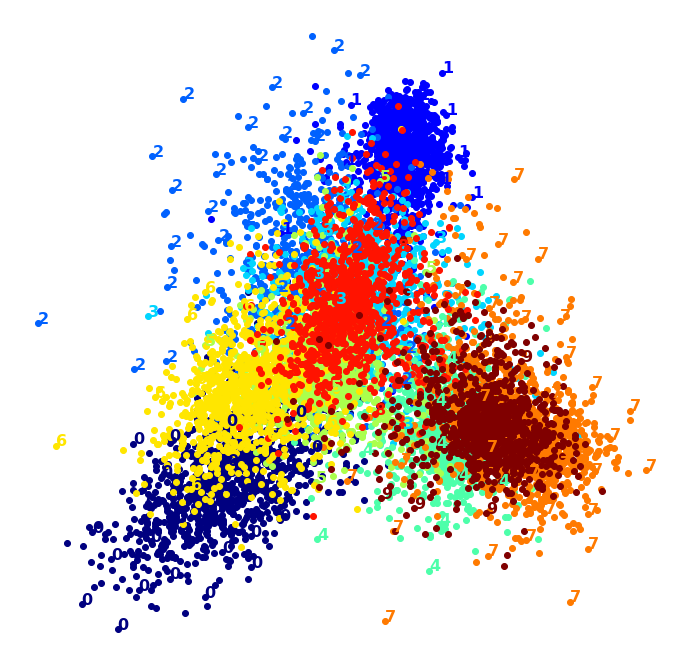

In [57]:
t08 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t18 = time.time()
print("LDA took: {:.1f}s".format(t18-t08))
plot_digits(X_lda_reduced, y, figsize=(12, 12))
plt.show()

    - LDA is very fast, yet like the previous algorithms, there's too much overlap. So from PCA, LLE, MDS and t-SNE, t-SNE produced the best results.
    Let's see how long it takes to train t-SNE

TSNE took: 40.0s


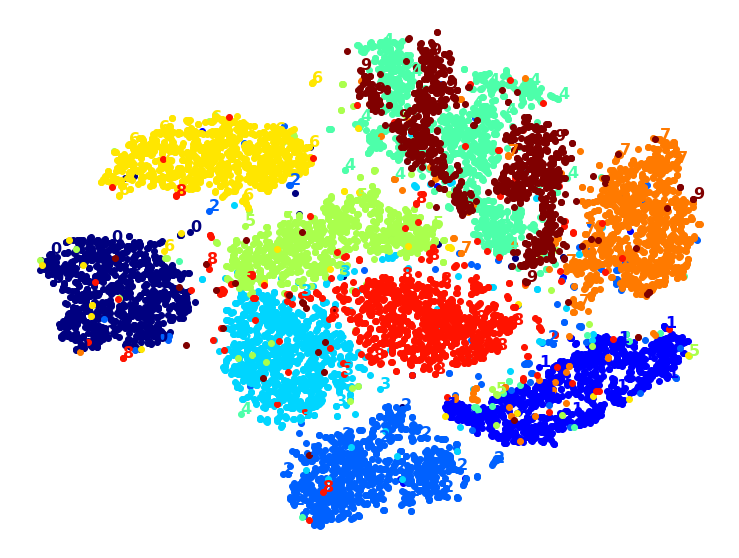

In [66]:
t09 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t19 = time.time()
print("TSNE took: {:.1f}s".format(t19-t09))
plot_digits(X_tsne_reduced, y)
plt.show()

    - t-SNE was slower than LLE, and LDA yet faster than MDS, and the results are impressive in comparisson to the others. Let's see if adding PCA will speed up the results

PCA and t-SNE took: 41.3


[]

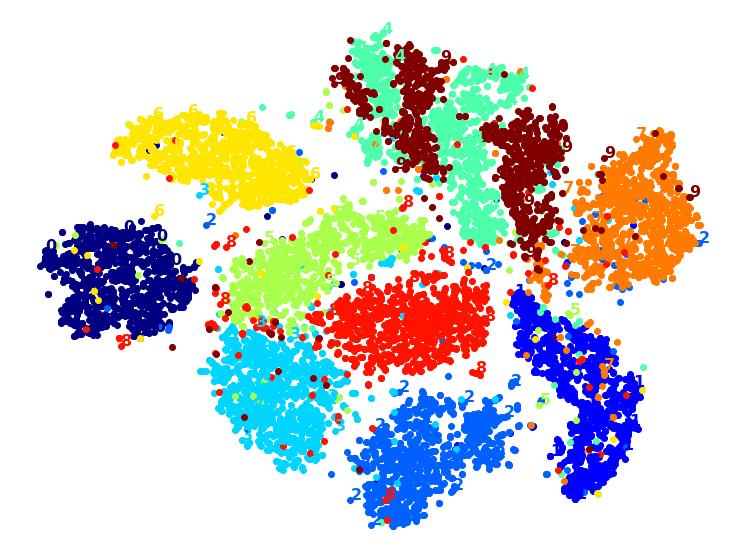

In [67]:
pca_tsne_pipeline = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42))
])

t091 = time.time()
X_pcatsne_reduced = pca_tsne_pipeline.fit_transform(X)
t191 = time.time()
print("PCA and t-SNE took: {:.1f}".format(t191-t091))
plot_digits(X_pcatsne_reduced, y)
plt.plot()

    - In our case, PCA didn't contribute to any speed up. But generally speaking, PCA should help improve the speed without damaging the results